In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [6]:
#path = Config().data_path()/'rossmann'
path = "../dl1/data/rossmann" # kaggle에서 받은 rossmann 데이터의 경로지정.
train_df = pd.read_pickle(path+'/train_clean')

In [7]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [8]:
n = len(train_df); n

844338

### Experimenting with a sample

In [9]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [10]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
468,470,5,NaN,50.0,61,15098
512,514,5,"Jan,Apr,Jul,Oct",1200.0,50,7568
1046,1049,5,"Jan,Apr,Jul,Oct",370.0,50,5135
1601,490,4,"Jan,Apr,Jul,Oct",660.0,59,8458
1845,734,4,"Mar,Jun,Sept,Dec",220.0,73,5725


In [11]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
423218,164,6,"Jan,Apr,Jul,Oct",1160.0,70,4642
423255,201,6,"Mar,Jun,Sept,Dec",20260.0,48,5243
423457,403,6,NaN,4970.0,48,4536
424143,1093,6,NaN,10450.0,82,6015
424840,678,5,"Jan,Apr,Jul,Oct",3250.0,53,6936


In [12]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [13]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
423218,NaN,6,"Jan,Apr,Jul,Oct",1160.0,70,4642
423255,NaN,6,"Mar,Jun,Sept,Dec",20260.0,48,5243
423457,NaN,6,NaN,4970.0,48,4536
424143,1093,6,NaN,10450.0,82,6015
424840,NaN,5,"Jan,Apr,Jul,Oct",3250.0,53,6936


In [14]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [15]:
small_train_df['PromoInterval'].cat.codes[:5]

468    -1
512     1
1046    1
1601    1
1845    2
dtype: int8

In [16]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [17]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
9226,291,3,NaN,2330.0,59,5679,True
104159,622,5,NaN,2330.0,69,4243,True
148598,291,5,NaN,2330.0,68,8727,True


### Preparing full data set

In [21]:
train_df = pd.read_pickle(path+'/train_clean')
test_df = pd.read_pickle(path+'/test_clean')

In [22]:
len(train_df),len(test_df)

(844338, 41088)

In [23]:
procs=[FillMissing, Categorify, Normalize]

In [24]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw'] # categorical features

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday'] # continuous features

In [25]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [26]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [27]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [28]:
valid_idx = range(cut)

In [29]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [30]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch()) # TabularData로 지정. tabular model을 불러와서 학습시킬 예정.

In [31]:
doc(FloatList)

## Model

In [32]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [33]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [34]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [35]:
len(data.train_ds.cont_names)

16

In [36]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


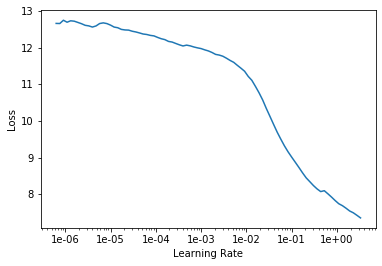

In [37]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.026222,0.021406,0.154613,01:36
1,0.017679,0.020430,0.132968,01:35
2,0.016740,0.017081,0.136942,01:35
3,0.011615,0.012016,0.112611,01:37
4,0.009754,0.010674,0.102484,01:35


In [39]:
learn.save('1')

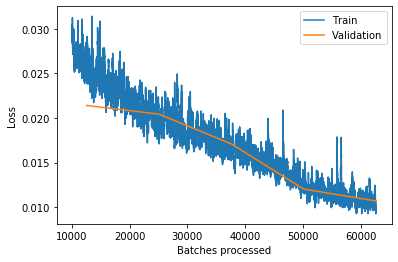

In [40]:
learn.recorder.plot_losses(skip_start=10000)

In [41]:
learn.load('1');

In [42]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010936,0.014001,0.110882,01:33
1,0.012833,0.012585,0.113080,01:36
2,0.010986,0.012917,0.116914,01:38
3,0.010370,0.012651,0.105885,01:31
4,0.010241,0.013365,0.108855,01:34


In [43]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011694,0.014671,0.114268,01:35
1,0.010481,0.014736,0.122075,01:35
2,0.010340,0.016948,0.130953,01:36
3,0.009563,0.014107,0.122638,01:36
4,0.008904,0.017144,0.136572,01:37


(10th place in the competition was 0.108)

In [44]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)

## Classnote

- ResNet34의 모델을 가지고 tabular data의 regression task를 해결했다. 원래 kaggle competition이었는데, 그 당시 우승은 xgboost가 했음에도 불구하고, 간단한 ResNet으로 꽤 높은 성능을 내는 것을 볼 수 있다. (Leaderboard 기준 당시 winner : 0.10021, 현재 모델 최종값 0.136572)
- fastai를 보면서 느끼는건 대부분의 task가 어렵지 않게 ResNet과 hyper-parameter tuning으로 꽤 SOTA 성능에 근접한 결과를 낸다는 것이다.
- ResNet 만세! (참고로 더 큰 ResNet55를 쓰면 더 올라갈것같았는데, (아마도)hyper-parameter tuning이 되지 않았는지 특별한 성능 향상은 없었다.